In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_PATH = "/content/drive/My Drive/Breast_Cancer_MRI"

In [ ]:
import os

# Define dataset path
DATASET_PATH = "/content/drive/My Drive/Breast_Cancer_MRI"

# categories in the path
CATEGORIES = ["normal", "benign", "malignant"]

# Check if the dataset folder exists
if os.path.exists(DATASET_PATH):
    print("Main dataset folder found!")
    print("Contents:", os.listdir(DATASET_PATH)) # prints all the folders in the path
else:
    print("Dataset folder not found! Check your path.")

# Inside each category, we check its content.
for category in CATEGORIES:
    category_path = os.path.join(DATASET_PATH, category)
    if os.path.exists(category_path):
        print(f"\n{category} contains:", os.listdir(category_path)[:5])
    else:
        print(f"Warning: {category} folder not found!")


Main dataset folder found!
Contents: ['normal', 'benign', 'malignant', 'unet_model.h5']

normal contains: ['normal (10)_mask.png', 'normal (1)_mask.png', 'normal (10).png', 'normal (1).png', 'normal (113)_mask.png']

benign contains: ['benign (100)_mask.png', 'benign (100).png', 'benign (1)_mask.png', 'benign (1).png', 'benign (10).png']

malignant contains: ['malignant (101).png', 'malignant (10).png', 'malignant (102)_mask.png', 'malignant (101)_mask.png', 'malignant (104)_mask.png']


In [ ]:
import cv2
import numpy as np

# Image size (modify based on dataset)
IMG_SIZE = 256

# Function to load images and masks
def load_dataset(dataset_path, categories, img_size=IMG_SIZE):
    images = []
    masks = []

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        image_files = sorted(os.listdir(category_path))  # Sort to align masks correctly

        for filename in image_files:
            if "_mask" in filename:  # Skip masks during first loop
                continue

            # Load MRI image
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (img_size, img_size))
            img = img / 255.0  # Normalize

            # Load corresponding mask
            mask_filename = filename.replace(".png", "_mask.png")  # Adjust if different naming format
            mask_path = os.path.join(category_path, mask_filename)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                continue
            mask = cv2.resize(mask, (img_size, img_size))
            mask = mask / 255.0  # Normalize mask to 0-1 range

            # Append to lists
            images.append(img)
            masks.append(mask)

    # Convert to NumPy arrays
    images = np.array(images).reshape(-1, img_size, img_size, 1)
    masks = np.array(masks).reshape(-1, img_size, img_size, 1)

    return images, masks

# Load dataset
X, Y = load_dataset(DATASET_PATH, CATEGORIES)

# Print dataset details
print(f"Total Images: {X.shape[0]}")
print(f"Image Shape: {X.shape[1:]}, Mask Shape: {Y.shape[1:]}")

# X = 780, 256, 256, 1 (780 greyscale  MRI images of size 256)
# Y = 780, 256, 256, 1 (780 Mask images corresponding to the MRI images of size 256)


Total Images: 780
Image Shape: (256, 256, 1), Mask Shape: (256, 256, 1)


In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset (80% train, 20% validation)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print dataset details
print(f"Training Samples: {X_train.shape[0]}")
print(f"Validation Samples: {X_val.shape[0]}")


Training Samples: 624
Validation Samples: 156


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_size=(256, 256, 1), dropout_rate=0.3):
    inputs = layers.Input(input_size)

    # Encoder with Dropout
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.Dropout(0.1)(c1)  # Dropout added
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.Dropout(0.1)(c2)  # Dropout added
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Dropout(0.2)(c3)  # Dropout added
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.Dropout(0.3)(c4)  # Dropout added
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.Dropout(0.3)(c5)  # Dropout added

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Model
    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

# Build U-Net model
model = unet_model()

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

# Print model summary to check for any changes after compiling
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=20,
                    batch_size=16)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(16, 256, 256, 1))
  warnings.warn(msg)


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.9181 - loss: 0.7473 - mean_io_u: 0.4610

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)


39/39 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.9182 - loss: 0.7413 - mean_io_u: 0.4610 - val_accuracy: 0.9198 - val_loss: 0.2842 - val_mean_io_u: 0.4610
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 54s 945ms/step - accuracy: 0.9297 - loss: 0.2526 - mean_io_u: 0.4659 - val_accuracy: 0.9198 - val_loss: 0.2713 - val_mean_io_u: 0.4610
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 865ms/step - accuracy: 0.9242 - loss: 0.2613 - mean_io_u: 0.4632 - val_accuracy: 0.9198 - val_loss: 0.2753 - val_mean_io_u: 0.4610
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 881ms/step - accuracy: 0.9191 - loss: 0.2745 - mean_io_u: 0.4607 - val_accuracy: 0.9198 - val_loss: 0.2685 - val_mean_io_u: 0.4610
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 43s 928ms/step - accuracy: 0.9149 - loss: 0.2774 - mean_io_u: 0.4586 - val_accuracy: 0.9198 - val_loss: 0.2528 - val_mean_io_u: 0.4610
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 39s 876ms/step - accuracy: 0.9223 - loss: 0.2528 - mean_io_u: 0.4622 - val_accuracy: 0.9198 - val_loss: 0.2583

In [ ]:
# Evaluate the model on validation data
val_loss, val_acc, val_miou = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")
print(f"Validation Mean IoU: {val_miou}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 73s 9s/step - accuracy: 0.9378 - loss: 0.1725 - mean_io_u: 0.4608
Validation Loss: 0.17104285955429077
Validation Accuracy: 0.9395848512649536
Validation Mean IoU: 0.46098122000694275


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


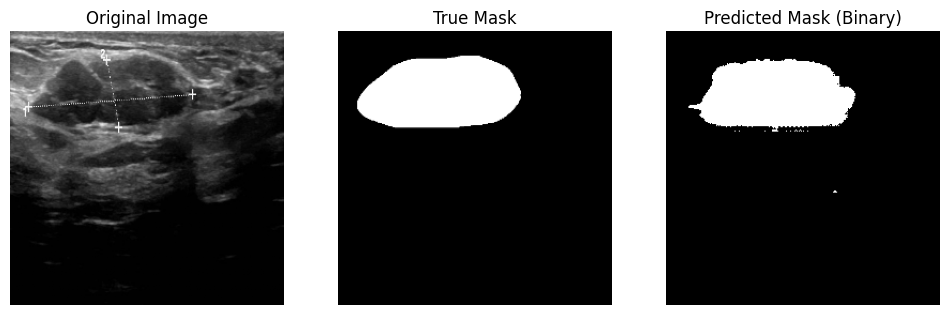

'\nimport matplotlib.pyplot as plt\n\n# Choose a random sample from the validation set\nidx = np.random.randint(0, X_val.shape[0])\n\n# Get the corresponding image, mask, and prediction\nimage = X_val[idx].reshape(IMG_SIZE, IMG_SIZE)\ntrue_mask = Y_val[idx].reshape(IMG_SIZE, IMG_SIZE)\npred_mask = model.predict(np.expand_dims(X_val[idx], axis=0)).reshape(IMG_SIZE, IMG_SIZE)\n\n# Plot the results\nplt.figure(figsize=(12, 6))\n\n# Original image\nplt.subplot(1, 3, 1)\nplt.imshow(image, cmap=\'gray\')\nplt.title("Original Image")\nplt.axis(\'off\')\n\n# True mask\nplt.subplot(1, 3, 2)\nplt.imshow(true_mask, cmap=\'gray\')\nplt.title("True Mask")\nplt.axis(\'off\')\n\n# Predicted mask\nplt.subplot(1, 3, 3)\nplt.imshow(pred_mask, cmap=\'gray\')\nplt.title("Predicted Mask")\nplt.axis(\'off\')\n\nplt.show()\n'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Choose a random sample from the validation set
idx = np.random.randint(0, X_val.shape[0])

# Get the corresponding image, mask, and prediction
image = X_val[idx].reshape(IMG_SIZE, IMG_SIZE)
true_mask = Y_val[idx].reshape(IMG_SIZE, IMG_SIZE)

# Predict the mask
pred_mask = model.predict(np.expand_dims(X_val[idx], axis=0)).reshape(IMG_SIZE, IMG_SIZE)

# Apply thresholding to make the predicted mask binary
threshold = 0.45  # You can tweak this value if needed
binary_pred_mask = (pred_mask > threshold).astype(np.uint8)  # Convert to binary (0 or 1)

# Plot the results
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# True mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap='gray')
plt.title("True Mask")
plt.axis('off')

# Predicted mask (Binary)
plt.subplot(1, 3, 3)
plt.imshow(binary_pred_mask, cmap='gray')
plt.title("Predicted Mask (Binary)")
plt.axis('off')

plt.show()

'''
import matplotlib.pyplot as plt

# Choose a random sample from the validation set
idx = np.random.randint(0, X_val.shape[0])

# Get the corresponding image, mask, and prediction
image = X_val[idx].reshape(IMG_SIZE, IMG_SIZE)
true_mask = Y_val[idx].reshape(IMG_SIZE, IMG_SIZE)
pred_mask = model.predict(np.expand_dims(X_val[idx], axis=0)).reshape(IMG_SIZE, IMG_SIZE)

# Plot the results
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# True mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap='gray')
plt.title("True Mask")
plt.axis('off')

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()
'''


In [ ]:
# Save the trained model
model.save('/content/drive/My Drive/Breast_Cancer_MRI/unet_model.h5')
